In [181]:
# 텐서플로를 활용한 구글넷 구현
import tensorflow as tf
from tensorflow.keras import Model, regularizers
# Model: Keras에서 신경망 모델을 정의할 때 사용하는 기본 클래스
# regularizers: 모델의 과적합 방지를 위한 정규화 도구 (L1, L2 정규화 등)


from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
# Flatten: 다차원 입력을 1차원 벡터로 변환
# Dense: 완전 연결층 (Fully Connected Layer)
# Dropout: 과적합 방지를 위한 뉴런 랜덤 비활성화
# Conv2D: 2D 합성곱 층 (Convolutional Layer)
# MaxPool2D: 최대 풀링 층 (특징 맵 크기 축소)
# BatchNormalization: 학습 속도 향상 및 안정화를 위한 배치 정규화
# Activation: 활성화 함수 적용 (ReLU, Sigmoid 등)
# Input: 모델의 입력 레이어 정의
# AveragePooling2D: 평균 풀링 층 (특징 맵 크기 축소)
# concatenate: 여러 레이어의 출력을 연결하는 층


from tensorflow.keras.callbacks import ReduceLROnPlateau
# ReduceLROnPlateau: 검증 손실이 개선되지 않을 경우 학습률(Learning Rate)을 자동으로 줄여주는 콜백 함수
import matplotlib.pyplot as plt


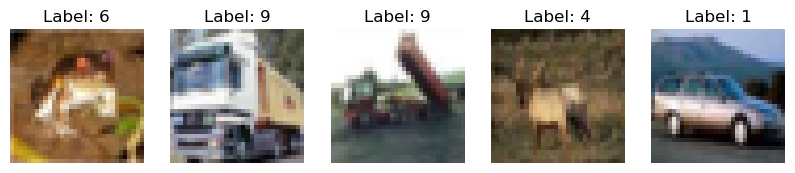

In [182]:
# 훈련 데이터와 테스트 데이터 로드
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
num_classes = 10


plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_x[i])
    plt.title(f"Label: {train_y[i][0]}")
    plt.axis("off")


plt.show()


In [183]:
# 각 픽셀이 가지고 있는 값의 범위가 0 ~ 255 이하로 큰 편이다.
# 따라서 스케일링을 통한 범위 조정이 필요하다.
print(f"스케일링 전 픽셀의 최대 값과 최소 값: {train_x.max()} ~ {train_x.min()}")
train_x = train_x / 255.0
test_x = test_x / 255.0


print(f"스케일링 후 펙셀의 최대 값과 최소 값: {train_x.min()} ~ {train_x.max()}")


스케일링 전 픽셀의 최대 값과 최소 값: 255 ~ 0
스케일링 후 펙셀의 최대 값과 최소 값: 0.0 ~ 1.0


In [184]:
# 하이퍼 파라미터 설정
image_size = (32, 32)
batch_size = 64
weight_decay = 5e-4
learning_rate = 1e-2
epochs = 40

# 가중치 감소(Weight Decay)는 L2 정규화의 일종으로, 모델의 과적합(overfitting)을 방지하기 위해 사용.
# weight_decay 값을 설정하면 모델의 가중치가 너무 커지는 것을 방지하여 일반화 성능을 향상.
# 일반적으로 5e-4 (0.0005) 정도의 작은 값을 사용하여 모델의 학습을 안정화.
# 1e-2 (0.01)는 비교적 큰 학습률로, 빠르게 학습을 진행하려는 설정.


In [185]:
# 합성곱 블록 함수 구성
# 입력 데이터 x를 합성곱 층에 통과시킨 뒤, 이어서 배치 정규화 층과 relu 활성화 함수층을 거친다.
# 이 블록은 구글넷뿐만 아니라 여러 합성곱 신경망에서 살펴볼 수 있는 패턴으로
# 모델이 이미지 데이터의 다양한 표현력을 빠르게 학습할 수 있다는 특징을 갖는다.
# 합성곱 층 중간에 삽입되는 L2 규제는 모델의 과적합을 방지한다.


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=0.0, strides=1):
    x = Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding="same",
        use_bias=False,
        kernel_regularizer=regularizers.l2(weight_decay),
    )(x)
    x = BatchNormalization(scale=False, axis=3)(x)
    x = Activation("relu")(x)
    return x


In [186]:
# 입셉션 모듈 함수
# 모듈은 입력 데이터를 받아 이를 네 개의 합성곱 블록에서 병렬적으로 처리한다
# br0 블록에서는 1 * 1 합성곱 층이, br1에서는 3 * 3 합성곱 층이, br2에서는 5 * 5 합성곱 층이 내재된다.
# br3에서는 최대 풀링 후 1 * 1 합성곱 층을 통해 채널 수를 조정한다.
# 마지막으로 concatenate 함수를 사용해 결합하벼, 결합 방향을 채널 방향인 axis=3으로 설정한다.
# filters_num_array는 각 블록마다 적용될 필터의 수를 담은 배열로, 총 네 개의 값을 요구한다.


def inception_module(x, filters_num_array, weight_decay=0.0):
    (br0_filters, br1_filters, br2_filters, br3_filters) = filters_num_array
    br0 = conv2d_bn_relu(
        x, filters=br0_filters, kernel_size=1, weight_decay=weight_decay
    )
    br1 = conv2d_bn_relu(
        x, filters=br1_filters[0], kernel_size=1, weight_decay=weight_decay
    )
    br1 = conv2d_bn_relu(
        br1, filters=br1_filters[1], kernel_size=3, weight_decay=weight_decay
    )
    br2 = conv2d_bn_relu(
        x, filters=br2_filters[0], kernel_size=1, weight_decay=weight_decay
    )
    br2 = conv2d_bn_relu(br2, filters=br2_filters[1], kernel_size=5)
    br3 = MaxPool2D(pool_size=3, strides=(1, 1), padding="same")(x)
    br3 = conv2d_bn_relu(
        br3, filters=br3_filters, kernel_size=1, weight_decay=weight_decay
    )
    x = concatenate([br0, br1, br2, br3], axis=3)
    return x


In [187]:
# 구글넷 구축을 위한 함수
def googlenet(input_shape, classes, weight_decay=0.0):
    input = Input(shape=input_shape)
    x = input

    # Input 함수를 사용하여 입력 텐서를 정의하고, 이후 초기 합성곱 층을 거쳐 특징을 추출한다.
    # 인셉션 모델을 통과하기 전, 합성곱 블록과 최대 풀링을 통해 이미지 사이즈가 축소된다.
    x = conv2d_bn_relu(x, filters=64, kernel_size=1, weight_decay=weight_decay)
    x = conv2d_bn_relu(x, filters=192, kernel_size=3, weight_decay=weight_decay)
    x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    # strides=2 → 커널이 2픽셀씩 이동하며 다운샘플링하여 출력 크기를 줄임.
    # 풀링 연산에서 strides는 해상도를 얼마나 빨리 축소할지 결정하는 요소.

    # 데이터는 총 9번의 인셉션 모둘을 거친다.
    # 이 과정은 좀 더 복잡하고 다양한 이미지 특징을 학습할 수 있도록 한다.
    x = inception_module(x, (64, (96, 128), (16, 32), 32), weight_decay=weight_decay)
    x = inception_module(x, (128, (128, 192), (32, 96), 64), weight_decay=weight_decay)

    # 인셉션 모듈 사이에는 최대 풀링 층이 위치해 있어, 특징 맵의 사이즈를 줄이고 특징만 보존한다.
    # 또한 이는 계산량을 감소시키고, 과적합을 방지하는 역할도 수행한다.
    x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)

    x = inception_module(x, (192, (96, 208), (16, 48), 64), weight_decay=weight_decay)
    x = inception_module(x, (160, (112, 224), (24, 64), 64), weight_decay=weight_decay)
    x = inception_module(x, (128, (128, 256), (24, 64), 64), weight_decay=weight_decay)
    x = inception_module(x, (112, (144, 288), (32, 64), 64), weight_decay=weight_decay)
    x = inception_module(
        x, (256, (160, 320), (32, 128), 128), weight_decay=weight_decay
    )
    x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)

    x = inception_module(
        x, (256, (160, 320), (32, 128), 128), weight_decay=weight_decay
    )
    x = inception_module(
        x, (384, (192, 384), (48, 128), 128), weight_decay=weight_decay
    )

    # 네트워크의 마지막 부분에는 평균 풀링 층과 밀집 연결층이 있다.
    # 풀링 층은 특징 맵을 작은 사이즈의 벡터로 압축하며,
    # 밀집 연결 층은 정해진 클래스 수만큼 데이터의 확률을 표현하여 분류한다.
    x = AveragePooling2D(pool_size=4, strides=1, padding="valid")(x)

    x = Flatten()(x)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input, output)
    return model


In [188]:
# 구글넷 정의 함수 모델 생성 및 컴파일
googlenet = googlenet(
    input_shape=(image_size[0], image_size[1], 3),
    classes=num_classes,
    weight_decay=weight_decay,
)

# momentum=0.9은 과거의 기울기를 90% 반영하여 학습을 빠르고 안정적으로 진행하는 역할을 한다.
# 공이 경사면을 굴러 내려올 때 속도가 붙듯이, 모멘텀은 가중치 업데이트 시 이전 업데이트의 관성을 추가하며 지역 최소 값에 갇히지 않도록 도움을 준다.

# 옵티마이저는 확률적 경사 하강법을 사용한다.
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
googlenet.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


In [189]:
# 캐라스의 콜백 중 모델의 학습 정도에 따라 동적 학습률을 조정하는 ReduceROnPlateau를 사용
# 학습 과정에서 정체되거나 개선이 더디게 진행될 때, 학습률을 줄여서 좀 더 세밀한 학습이 이뤄지도록 한다.
# monitor 인수는 모델링할 지표를 지정하며, 거기에서는 검증 손실 값에 집중한다.
# factor는 학습률에 곱할 값을 의미, 이 값이 0.5인 경우 기존 학습률에 0.5를 곱하여 값을 반으로 축소한다.
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-7, verbose=1
)
history = googlenet.fit(
    x=train_x,
    y=train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[reduce_lr],
)


Epoch 1/40
439/625 ━━━━━━━━━━━━━━━━━━━━ 3:48 1s/step - accuracy: 0.3595 - loss: 5.6022

KeyboardInterrupt: 

In [190]:
from tensorflow.keras.models import load_model

googlenet = load_model('googlenet_model.keras')

In [191]:
# 테스트 셋으로 평가 
googlenet.evaluate(test_x, test_y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 102s 301ms/step - accuracy: 0.8884 - loss: 0.7778


[0.7864517569541931, 0.8859000205993652]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


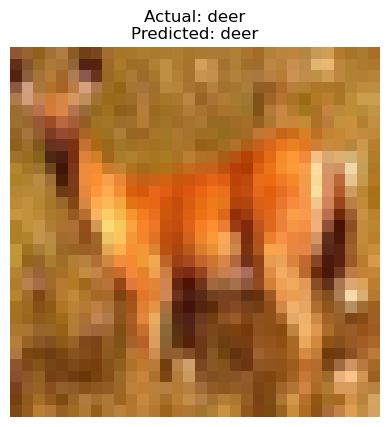

In [193]:
import numpy as np
import matplotlib.pyplot as plt
import random


# 테스트 데이터에서 임의의 이미지 선택
random_index = random.randint(0, len(test_x) - 1)
image = test_x[random_index]  # 원본 이미지
label = test_y[random_index]  # 실제 라벨


# 모델 입력 형식에 맞게 차원 확장 (배치 차원 추가)
image_expanded = np.expand_dims(image, axis=0)  # (32, 32, 3) → (1, 32, 32, 3)


# 모델 예측 수행
predictions = googlenet.predict(image_expanded)
predicted_class = np.argmax(predictions)  # 가장 확률이 높은 클래스 선택


# CIFAR-10 클래스 이름
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


# 결과 출력
plt.imshow(image)
plt.title(f"Actual: {class_names[label[0]]}\nPredicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()
